In [1]:
%config Completer.use_jedi = False

In [1]:
import json
import os
import sys

import mne
import numpy as np
import pandas as pd

import pac


suffix = '_1_200'  # '_1ch_nv'
gamma = [1, 200]
beta = [1, 50]

In [2]:
def create_elc_file(task):
    with open(os.path.join(task.dir, task.file_formatter.format('electrodes.elc')), 'w') as elc:
        locs = pd.read_csv(os.path.join(
            task.dir, task.file_formatter.format('electrodes.tsv')), sep="\t")
        locs = locs.iloc[:64]
        locs = locs.append(pd.DataFrame([{'name': 'RPA', 'x': 0, 'y': 1, 'z': 0},
                                         {'name': 'LPA', 'x': 0, 'y': -1, 'z': 0},
                                         {'name': 'Nz', 'x': 1, 'y': 0, 'z': 0}, ]))
        elc.write('\n'.join([
            '# ASA electrode file',
            'ReferenceLabel	avg',
            'UnitPosition	mm',
            f'NumberPositions=	{locs.shape[0]}',
            'Positions',
        ]))
        elc.write('\n')
        elc.write(
            '\n'.join(locs.agg(lambda loc: f'{loc.x}\t{loc.y}\t{loc.z}', axis=1)))
        elc.write('\n')
        elc.write('Labels\n')
        elc.write('\n'.join(locs.name))

In [3]:
def create_tasks_df(ds_path=None):
    if ds_path is None:
        with open('config.json') as f:
            config = json.load(f)
        base_path = config['BASE_PATH']
        ds_path = os.path.join(base_path, 'ds003490-download')

    df = pd.read_csv(os.path.join(ds_path, 'participants.tsv'), sep="\t")
    tasks = []

    for _, participant in df.iterrows():
        if participant.Group == 'PD':
            sessions = [(1, 1 * (participant.sess1_Med == 'ON')),
                        (2, 1 * (participant.sess2_Med == 'ON'))]
        else:
            sessions = [(1, 2)]

        for sess, pd_drug_type in sessions:
            participant_tasks = {}
            participant_tasks['participant_id'] = participant['participant_id']
            participant_tasks['pd_drug_type'] = pd_drug_type
            participant_tasks['isMale'] = participant['sex'] == 'Male'
            participant_tasks['age'] = participant['age']
            participant_tasks['dir'] = os.path.join(ds_path, participant['participant_id'], f'ses-{sess:02}', 'eeg', )
            participant_tasks[
                'file'] = f'{participant["participant_id"]}_ses-{sess:02}_eeg_{participant["participant_id"]}_ses-{sess:02}_task-Rest_eeg.mat'
            participant_tasks['file_formatter'] = f'{participant["participant_id"]}_ses-{sess:02}_task-Rest_{{}}'
            participant_tasks['path'] = os.path.join(
                participant_tasks['dir'], participant_tasks['file'])

            tasks.append(participant_tasks)

    tasks_df = pd.DataFrame(tasks)

    return tasks_df


def _test_tasks_df(tasks_df, i=0):
    task = tasks_df.iloc[i]

    assert os.path.exists(task.path)

    ds = sio.loadmat(task.path)

    ds['data'] = ds['EEG']

    nbchan = ds['data'][0, 0]['nbchan'][0, 0]  # .dtype
    Fs = ds['data'][0, 0]['srate'][0, 0]
    times = ds['data'][0, 0]['times']
    data = ds['data'][0, 0]['data']

    dtypes = [k for k in ds['data'][0, 0]['event'].dtype.names]
    events = pd.DataFrame([{n: event[n].item() if event[n].size > 0 else None for n in dtypes}
                           for event in ds['data'][0, 0]['event'][0]])

    electrodes = pd.read_csv(os.path.join(
        task['dir'], task['file_formatter'].format('electrodes.tsv')), sep='\t')

    reject = ds['data'][0, 0]['reject']

    print(events)


# Create Task list in `tasks_df`

In [4]:
def check_completed(task, event=None) -> bool:
    json_path = os.path.join(task['dir'], task['file_formatter'].format(f'completed{suffix}.json'))
    completed = {}
    if os.path.exists(json_path):
        with open(json_path) as f:
            completed = json.load(f)
    
    if event is None:
        return completed.get('total', False)
    else:
        return completed.get(event, False)


def update_completed(task, event=None) -> bool:
    json_path = os.path.join(task['dir'], task['file_formatter'].format(f'completed{suffix}.json'))
    completed = {}
    if os.path.exists(json_path):
        with open(json_path) as f:
            completed = json.load(f)

    if event is None:
        completed['total'] = True
    else:
        completed[event] = True
        
    with open(json_path, 'w') as f:
        json.dump(completed, f)


In [5]:
def analyse_erps(erps: dict, task=None):
    mvls = {}
    mvl_2ds = {}
    
    groups = ['PD Med Off', 'PD Med On', 'CTL']

    for event_type, erp in erps.items():
        mvl_2d = np.zeros(
            (erp.info['nchan'], erp.info['nchan'], gamma[1] - gamma[0] + 1, beta[1] - beta[0] + 1))
        mvl = np.zeros((erp.info['nchan'], erp.info['nchan'],))
        tfds = {}

        erp_df = erp.to_data_frame()
        erp_df = erp_df.set_index('time')

        if task is not None:
            print(f'{task.participant_id} {groups[task.pd_drug_type]:10} {event_type} tfd started')

        for ch in erp_df:
            tfd = pac.rid_rihaczek(erp_df[ch], int(erp.info['sfreq']))
            tfds[ch] = tfd

        for chx, chxname in enumerate(erp_df):
            chy = chx
            chyname = chxname
            # for chy, chyname in enumerate(erp_df):
                # print(chxname, chyname)

                # todo:
                # if(check_completed(task, f'{event_type}_{chxname}_{chyname}')):
                #     continue

            mvl_2d[chx, chy] = pac.tfMVL_tfd2_2d(
                tfds[chxname], tfds[chyname], gamma, beta)
            mvl[chx, chy] = mvl_2d[chx, chy].sum()
            # mvl[chx, chy] = pac.tfMVL_tfd2(
            #     tfds[chxname], tfds[chyname], gamma, beta)

        mvls[event_type] = mvl
        mvl_2ds[event_type] = mvl_2d

    return mvls, mvl_2ds


In [6]:
def analyse_sub(task):
    if (check_completed(task)):
        return

    raw = mne.io.read_raw_eeglab(os.path.join(task['dir'], 'pre_' + task['file_formatter'].format('eeg.set')),
                                 preload=True, verbose=0)
    # raw.drop_channels(['X', 'Y', 'Z'])
    raw.drop_channels(['VEOG'])
    raw.set_eeg_reference()
    
    for ch in raw._data:
        ch -= ch.mean()
        ch /= ch.std()

    # create_elc_file(task)
    # montage = mne.channels.read_custom_montage(os.path.join(
    #     task.dir, task.file_formatter.format('electrodes.elc')))
    montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')
    raw.set_montage(montage)

    # mne.viz.plot_topomap(raw._data[:, 194000], raw.info, axes=ax,
    #                      show=False)

    eeg_picks = mne.pick_types(raw.info, eeg=True, meg=False, eog=True)
    # freqs = (60, 120, 180, 240)
    # raw_notch = raw.copy().notch_filter(freqs=freqs, picks=eeg_picks, verbose=0)
    # raw_filtered = raw_notch.copy().filter(l_freq=1, h_freq=150, verbose=0)


    # I have not applied baseline correction
    events, event_dict = mne.events_from_annotations(raw, verbose=0)
    epochs = mne.Epochs(raw, events, event_id=event_dict,
                        tmin=-0.2, tmax=1.45, preload=True, verbose=0)

    selected_events = ['S200', 'S201', 'S202']
    event_types = {'S200': 'Target', 'S201': 'Standard', 'S202':'Novelty'}
    
    erps = {}
    epochs_data = {}
    for ev in selected_events:
        erps[ev] = epochs[ev].average()
        if event_types[ev] in ['Target', 'Standard']:
            epochs_data[ev] = epochs[ev]._data[:, :, -601:]
        else:
            epochs_data[ev] = epochs[ev]._data[:, :, :601]

        
    np.savez_compressed(os.path.join(task['dir'], task['file_formatter'].format(f'epochs')),
                        **epochs_data)
    
    np.savez_compressed(os.path.join(task['dir'], task['file_formatter'].format(f'erps')),
                        **erps)
    
#     return

    mvls, mvl_2ds = analyse_erps(erps, task)
    np.savez_compressed(os.path.join(task['dir'], task['file_formatter'].format(f'mvls{suffix}')),
                        **mvls)
    np.savez_compressed(os.path.join(task['dir'], task['file_formatter'].format(f'mvl_2ds{suffix}')),
                        **mvl_2ds)
    update_completed(task)
    print(f'{task.participant_id} completed')


# Test on single task

In [11]:
for task in tasks_df.iloc[:1].iloc: 
    print(task.participant_id, task.pd_drug_type)
    raw = mne.io.read_raw_eeglab(os.path.join(task['dir'], 'pre_' + task['file_formatter'].format('eeg.set')),
                                 preload=True, verbose=0)
    # raw.drop_channels(['X', 'Y', 'Z'])
    # raw.drop_channels(['VEOG'])
    # raw.set_eeg_reference()

    for ch in raw._data:
        ch -= ch.mean()
        ch /= ch.std()

    # create_elc_file(task)
    # montage = mne.channels.read_custom_montage(os.path.join(
    #     task.dir, task.file_formatter.format('electrodes.elc')))
    montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')
    raw.set_montage(montage)

    # mne.viz.plot_topomap(raw._data[:, 194000], raw.info, axes=ax,
    #                      show=False)

    # eeg_picks = mne.pick_types(raw.info, eeg=True, meg=False, eog=True)
    # freqs = (60, 120, 180, 240)
    # raw_notch = raw.copy().notch_filter(freqs=freqs, picks=eeg_picks, verbose=0)
    # raw_filtered = raw_notch.copy().filter(l_freq=1, h_freq=150, verbose=0)

    events, event_dict = mne.events_from_annotations(raw, verbose=0)

    selected_events = ['S200', 'S201', 'S202']
    event_types = {'S200': 'Target', 'S201': 'Standard', 'S202': 'Novelty'}
    kwargs = {'S200': {'baseline': (0.250, 0.450), 'tmin': 0.250, 'tmax': 1.450},
              'S201': {'baseline': (0.250, 0.450), 'tmin': 0.250, 'tmax': 1.450},
              'S202': {'baseline': (-.200,     0), 'tmin': -.200, 'tmax': 1.000}, }

    erps = {}
    epochs_data = {}
    for ev in selected_events:
        epochs = mne.Epochs(raw, events[events[:, 2] == event_dict[ev]],
                            event_id={ev: event_dict[ev]}, preload=True, verbose=0, **(kwargs[ev]))
        erps[ev] = epochs[ev].average()
        epochs_data[ev] = epochs[ev]._data


sub-001 1


<ipython-input-11-be64d22855f5>:4: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  preload=True, verbose=0)


In [12]:
    mvls = {}
    mvl_2ds = {}
    mvl_2d_times = {}

    steps = list(range(-200, 1000 + 1, 200))

    groups = ['PD Med Off', 'PD Med On', 'CTL']

    # for event_type, erp in erps.items():
    #     mvl_2d = np.zeros(
    #         (erp.info['nchan'], erp.info['nchan'], gamma[1] - gamma[0] + 1, beta[1] - beta[0] + 1))
    #     mvl_2d_time = np.zeros((erp.info['nchan'], gamma[1] - gamma[0] + 1,
    #                             beta[1] - beta[0] + 1, len(steps) - 1))

    #     mvl = np.zeros((erp.info['nchan'], erp.info['nchan'],))
    #     tfds = {}
    #     tfds_time = {}

    #     erp_df = erp.to_data_frame()
    #     erp_df.time = list(range(-200, 1000 + 1, 2))
    #     erp_df = erp_df.set_index('time')

    #     if task is not None:
    #         print(
    #             f'{task.participant_id} {groups[task.pd_drug_type]:10} {event_type} tfd started')

    #     for ch in erp_df:
    #         tfd = pac.rid_rihaczek(erp_df[ch], int(erp.info['sfreq']))
    #         tfds[ch] = tfd

    #         tfd_time = []

    #         for i, ts in enumerate(zip(steps[:-1], steps[1:])):
    #             tstart, tend = ts
    #             # print(tstart, tend)
    #             ind_start = np.where(erp_df.index == tstart)[0][0]
    #             ind_end = np.where(erp_df.index == tend)[0][0]
    #             tfd_time.append(pac.rid_rihaczek(
    #                 erp_df[ch][ind_start:ind_end], int(erp.info['sfreq'])))
    #         tfds_time[ch] = tfd_time


In [14]:
erp = erps['S200']
erp_df = erp.to_data_frame()
erp_df.time = list(range(-200, 1000 + 1, 2))
erp_df = erp_df.set_index('time')

tfds_time = {}
tfd_time = []
ch = erp_df.columns[0]

for i, ts in enumerate(zip(steps[:-1], steps[1:])):
    tstart, tend = ts
    # print(tstart, tend)
    ind_start = np.where(erp_df.index == tstart)[0][0]
    ind_end = np.where(erp_df.index == tend)[0][0]
    tfd_time.append(pac.rid_rihaczek(
        erp_df[ch][ind_start:ind_end], int(erp.info['sfreq'])))
tfds_time[ch] = tfd_time

In [35]:
mvl_80_12 = pac.tfMVL(erp_df[ch][ind_start:ind_end], [80, 80], [12, 12], 500)
mvl_80_12*1e-12

0.161870674434485

In [36]:
rid = pac.rid_rihaczek(erp_df[ch][ind_start:ind_end], int(erp.info['sfreq']))
A = pac.tfMVL_tfd2_2d(rid, rid, gamma, beta)
A[79, 11]*1e-12

0.161870674434485

In [37]:
A[79, 11] == mvl_80_12

True

# Main

In [10]:
if __name__ == '__main__':
    tasks_df = create_tasks_df()

#     analyse_sub(tasks_df.iloc[0])

    # from multiprocessing import Pool
    # with Pool(4) as p:
    #    p.map(analyse_sub, tasks_df.iloc)

    for task in tasks_df.iloc:
        analyse_sub(task)
    print('finished')

finished


In [8]:
task = tasks_df.iloc[0]
if 1:
#     if (check_completed(task)):
#         return

    raw = mne.io.read_raw_eeglab(os.path.join(task['dir'], 'pre_' + task['file_formatter'].format('eeg.set')),
                                 preload=True, verbose=0)
    # raw.drop_channels(['X', 'Y', 'Z'])
    raw.drop_channels(['VEOG'])
    raw.set_eeg_reference()
    
    for ch in raw._data:
        ch -= ch.mean()
        ch /= ch.std()
        ch *= 1e-6

    # create_elc_file(task)
    # montage = mne.channels.read_custom_montage(os.path.join(
    #     task.dir, task.file_formatter.format('electrodes.elc')))
    montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')
    raw.set_montage(montage)

    # mne.viz.plot_topomap(raw._data[:, 194000], raw.info, axes=ax,
    #                      show=False)

    eeg_picks = mne.pick_types(raw.info, eeg=True, meg=False, eog=True)
    # freqs = (60, 120, 180, 240)
    # raw_notch = raw.copy().notch_filter(freqs=freqs, picks=eeg_picks, verbose=0)
    # raw_filtered = raw_notch.copy().filter(l_freq=1, h_freq=150, verbose=0)

    events, event_dict = mne.events_from_annotations(raw, verbose=0)
    epochs = mne.Epochs(raw, events, event_id=event_dict,
                        tmin=-0.2, tmax=1, preload=True, verbose=0)

    selected_events = ['S200', 'S201', 'S202']
    erps = {}
    epochs_data = {}
    for ev in selected_events:
        erps[ev] = epochs[ev].average()
        epochs_data[ev] = epochs[ev]._data

<ipython-input-8-82bfef73693f>:7: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  preload=True, verbose=0)


In [9]:
epochs['S200']._data.shape

(30, 63, 601)

# plots

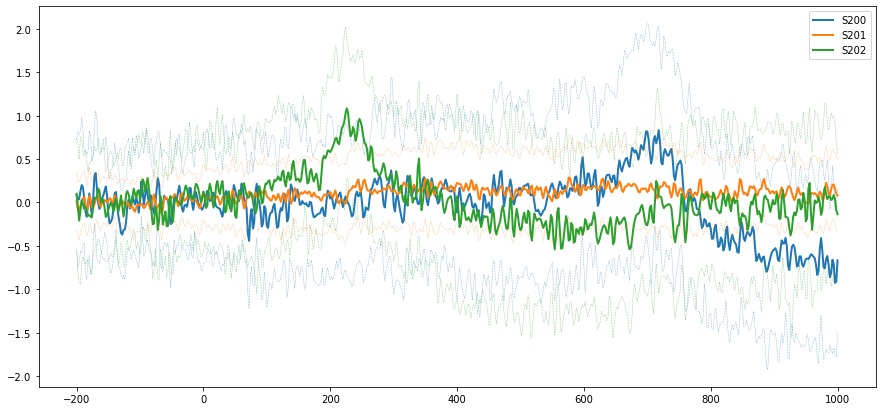

In [143]:
import matplotlib.pyplot as plt

erps_df = {}

plt.figure(figsize=(15, 7))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, ev in enumerate(selected_events):
    erps_df[ev] = erps[ev].to_data_frame()
    erps_df[ev] = erps_df[ev].set_index('time')
    
    
#     plt.subplot(3, 1, i+1)
    mean = epochs[ev]._data.mean(axis=0)
    std = epochs[ev]._data.std(axis=0)
    mean_df = epochs[ev].average().to_data_frame()
    mean_df = mean_df.set_index('time')
    std_df = epochs[ev].standard_error().to_data_frame()
    std_df = std_df.set_index('time')

#     plt.figure(figsize=(15, 7))
    
    plt.plot((mean_df['Fp1']), linewidth=2, color=colors[i], label=ev)
    plt.plot((mean_df['Fp1'] + 5*std_df['Fp1']), linestyle='--', linewidth=0.5, color=colors[i], alpha=0.5)
    plt.plot((mean_df['Fp1'] - 5*std_df['Fp1']), linestyle='--', linewidth=0.5, color=colors[i], alpha=0.5)
    
plt.legend()

plt.show()

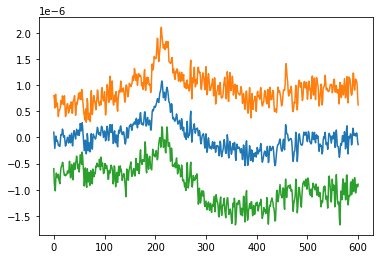

In [130]:
mean = epochs[ev]._data[:, 0, :].mean(axis=0)
std  = epochs[ev]._data[:, 0, :].std (axis=0)

plt.plot(mean)
plt.plot(mean + std)
plt.plot(mean - std)
plt.show()


Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


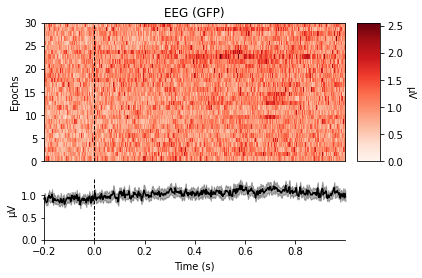

[<Figure size 432x288 with 3 Axes>]

In [85]:
epo = epochs['S200']
epo.plot_image()

In [146]:
task

participant_id                                              sub-001
pd_drug_type                                                      1
isMale                                                         True
age                                                              75
dir               /home/kiani/DS/ds003490-download/sub-001/ses-0...
file              sub-001_ses-01_eeg_sub-001_ses-01_task-Rest_ee...
file_formatter                          sub-001_ses-01_task-Rest_{}
path              /home/kiani/DS/ds003490-download/sub-001/ses-0...
Name: 0, dtype: object

array([[ 7.05860789e-24,  1.41172158e-23,  2.11758237e-23, ...,
        -7.05860789e-24, -3.52930395e-24, -8.82325987e-25],
       [ 8.82325987e-24, -7.05860789e-24,  2.47051276e-23, ...,
        -3.52930395e-24,  8.82325987e-25,  0.00000000e+00],
       [ 4.63221143e-24, -1.05879118e-23, -1.76465197e-24, ...,
         1.41172158e-23,  1.41172158e-23,  0.00000000e+00],
       ...,
       [-2.47051276e-23,  2.11758237e-23,  1.36760528e-23, ...,
         1.05879118e-23, -1.05879118e-23,  2.82344316e-23],
       [ 2.11758237e-23, -7.05860789e-24, -1.41172158e-23, ...,
        -7.05860789e-24, -7.05860789e-24,  2.02934977e-23],
       [-3.52930395e-24, -3.52930395e-24, -7.05860789e-24, ...,
         0.00000000e+00,  0.00000000e+00,  3.52930395e-24]])

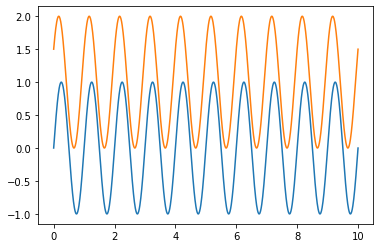

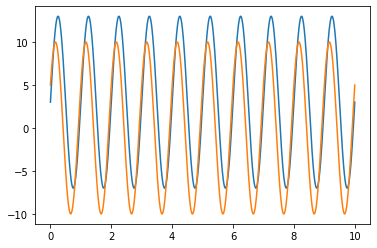

In [144]:
t = np.linspace(0, 10, 1000)
x1 = np.sin(2*np.pi*t)
x2 = np.sin(2*np.pi*t + np.pi/6)

plt.plot(t, x1)
plt.plot(t, 1 + x2)
plt.show()

plt.plot(t, 10*x1+3)
plt.plot(t, 10*x2)
plt.show()

In [145]:
print(x1.mean(), x1.std())
print((1 + x2).mean(), (1 + x2).std())
print((10*x1+3).mean(), (10*x1+3).std())
print((10*x2).mean(), (10*x2).std())

-7.460698725481052e-17 0.7067531393633849
1.0005 0.7069298055677099
2.999999999999999 7.067531393633849
0.004999999999998636 7.069298055677098
